In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#import math

In [77]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:1000] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente']]
    bairros = pd.unique(df['bairroPaciente'])

    clusters = []
    for bairro in bairros:
        cluster = []
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                if(df.loc[i][2] == 'Positivo'):
                    resultado = 1
                else:
                    resultado = 0
                cluster.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3]])
        clusters.append(cluster)

    novo_df = []
    for cluster in clusters:
        for i in range(len(cluster)):
            novo_df.append(cluster[i])

    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente'}, inplace=True)    
    return novo_df

In [78]:
df = pre_processamento()

In [79]:
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO
1,VARJOTA,FORTALEZA,0,FEMININO
2,VARJOTA,PACATUBA,0,FEMININO
3,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO
4,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO
...,...,...,...,...
995,MANGA,BATURITÉ,1,FEMININO
996,MORADA DOS VENTOS 1,CRATEUS,0,FEMININO
997,PRACINHA,PACATUBA,1,FEMININO
998,FLORES,ITAPIPOCA,1,MASCULINO


In [80]:
def ajustar(df):
    bairros = pd.unique(df['bairro_paciente'])
    casos_bairros = []
    for bairro in bairros:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                count = count + 1
        casos_bairros.append([bairro, count])
    casos_bairros = pd.DataFrame(casos_bairros)
    casos_bairros.rename(columns={0: 'bairro', 1: 'count'}, inplace=True)
    ordem = np.arange(1,len(casos_bairros)+1)#np.arange(-1,-(len(casos_bairros)+1), -1)
    casos_bairros['ordem'] = pd.Series(ordem, index=casos_bairros.index)
    return casos_bairros

In [81]:
dataset = ajustar(df)
dataset

,bairro,count,ordem
0,VILA PERI,1,1
1,VARJOTA,2,2
2,NOVA METROPOLE JUREMA,1,3
3,PARQUE POTIRA JUREMA,1,4
4,PINHEIRO,1,5
...,...,...,...
494,MANGA,1,495
495,MORADA DOS VENTOS 1,1,496
496,PRACINHA,1,497
497,FLORES,1,498


In [82]:
def query_topk(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmax()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])#(copia.loc[indice][0])#
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output

In [83]:
query_topk(dataset, 10)

,bairro,count
0,CENTRO,190
1,ZONA RURAL,46
2,ARATURI,13
3,SANTO ANTONIO,9
4,PLANALTO,8
5,JURITIANHA,8
6,JUREMA,7
7,PAVUNA,7
8,NOVO MARANGUAPE,7
9,PRECABURA,6


In [84]:
def score_function(registro, saida):
    if(registro[0] == saida):
        return -registro[2]
    else:
        return 0

In [85]:
def sensibilidade(dataset):
    return 1

# LAPLACE

In [86]:
def laplace(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_bairros = np.array(query['bairro'])
    output = []
    np.random.seed(123)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    dados = {
        'bairro': coluna_bairros,
        'count': output
    }
    
    df = pd.DataFrame(dados, columns = ['bairro', 'count'])
    return df.sort_values(by=['count'],ascending=False)

In [87]:
budgets = [0.1, 1, 10]
bairros = []
k = 10
for budget in budgets:
    a = laplace(budget, sensibilidade(dataset), query_topk(dataset, 10), dataset, 10)
    a = np.array(a)
    print("epsilon: {}\ntop-k:\n{}\n\n".format(budget, a))
    bairros.append(a[:,0])

epsilon: 0.1
top-k:
[['CENTRO' 194.9912496292116]
 ['ZONA RURAL' 40.418707789026975]
 ['JUREMA' 39.57834888254776]
 ['PLANALTO' 13.779237549274969]
 ['PAVUNA' 11.614950931917797]
 ['SANTO ANTONIO' 10.08286501254742]
 ['NOVO MARANGUAPE' 6.6111758470501565]
 ['JURITIANHA' 6.330157277395263]
 ['ARATURI' 5.0968731526788345]
 ['PRECABURA' 3.5695348775144327]]


epsilon: 1
top-k:
[['CENTRO' 190.49912496292117]
 ['ZONA RURAL' 45.4418707789027]
 ['ARATURI' 12.209687315267884]
 ['JUREMA' 10.257834888254775]
 ['SANTO ANTONIO' 9.108286501254742]
 ['PLANALTO' 8.577923754927497]
 ['JURITIANHA' 7.833015727739526]
 ['PAVUNA' 7.46149509319178]
 ['NOVO MARANGUAPE' 6.961117584705016]
 ['PRECABURA' 5.756953487751443]]


epsilon: 10
top-k:
[['CENTRO' 190.0499124962921]
 ['ZONA RURAL' 45.94418707789027]
 ['ARATURI' 12.920968731526788]
 ['SANTO ANTONIO' 9.010828650125474]
 ['PLANALTO' 8.057792375492749]
 ['JURITIANHA' 7.983301572773953]
 ['JUREMA' 7.325783488825477]
 ['PAVUNA' 7.046149509319178]
 ['NOVO MAR

In [88]:
erros_laplace = []
k = 10
top = list(query_topk(dataset, 10)['bairro'])
for bairro in bairros:
    erro_bairro_lap = [0]*10
    if(top[0] != bairro[0]):
         erro_bairro_lap[0] = 1
    for i in range(1, len(bairro)):
        if(top[i] != bairro[i]):
            for j in range(0, i):
                erro_bairro_lap[i] = 1 + erro_bairro_lap[j]
    erros_laplace.append(erro_bairro_lap)

In [89]:
erros_laplace

[[0, 0, 1, 2, 3, 4, 5, 6, 7, 0],
 [0, 0, 0, 1, 2, 3, 4, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

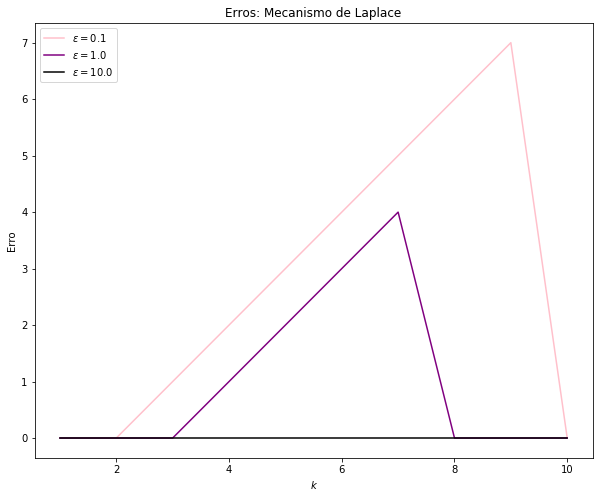

In [90]:
cores = ['pink', 'purple', 'black']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_laplace, budgets, cores):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'$\epsilon = %.1f$' % (budget))
    
plt.xlabel('$k$')
plt.ylabel('Erro')
plt.title('Erros: Mecanismo de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

# EXPONENCIAL

In [91]:
def dp_query(budget, sensibilidade, dataset, k):
    budget = budget/k
    probabilidades = []
    pk = []
    saidas = dataset['bairro']
    xk = np.arange(len(saidas))
    for out in saidas:
        linha = []
        for i in range(len(dataset)):
            registro = dataset.loc[i]
            numerador = np.exp(budget*score_function(registro,out)/(2*sensibilidade))
            denominador = 0
            for saida in saidas:
                denominador += np.exp(budget*score_function(registro, saida)/(2*sensibilidade))
            linha.append(numerador/denominador)
        probabilidades.append(linha)
    for prob in probabilidades:
        pk.append(np.sum(prob)/np.sum(probabilidades))
    dist = stats.rv_discrete(name='dist', values=(xk, pk))
    output = []

    for i in range(k):
        valido = False
        while(not valido):
            indice = dist.rvs()
            if([saidas[indice], dataset.loc[indice][1]] not in output):
                output.append([saidas[indice], dataset.loc[indice][1]])
                valido = True
        
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output.sort_values(by=['count'],ascending=False)

In [92]:
budgets = [0.1, 1, 10]
bairros = []
k = 10
for budget in budgets:
    a = dp_query(budget, sensibilidade(dataset), dataset, k)
    a = np.array(a)
    print("epsilon: {}\ntop-k:\n{}\n\n".format(budget, a))
    bairros.append(a[:,0])

epsilon: 0.1
top-k:
[['ALTO DO CRISTO' 3]
 ['FÁTIMA' 2]
 ['PACATUBA' 2]
 ['RODOVIARIA' 1]
 ['ABREULANDIA' 1]
 ['TABAPUAZINHO' 1]
 ['CARRAPATEIRAS' 1]
 ['CROATÁ I' 1]
 ['CAMPO VELHO' 1]
 ['PALESTINA- SEDE II' 1]]


epsilon: 1
top-k:
[['JEREISSATI 2' 6]
 ['SEMINÁRIO' 3]
 ['ALTO ALEGRE' 2]
 ['DAMAS' 1]
 ['SANTOS DUMONT' 1]
 ['SEDE II' 1]
 ['CENTRO SUCESSO' 1]
 ['OLINDA' 1]
 ['UBAUNA' 1]
 ['PAJUCARA' 1]]


epsilon: 10
top-k:
[['ARATURI' 13]
 ['PARQUE SANTO ANTONIO' 3]
 ['IPARANA' 2]
 ['ALTO DA BRASILIA' 2]
 ['PRAIA DO FUTURO I' 1]
 ['NOVO ANGELIN' 1]
 ['PQ. POTIRA I' 1]
 ['LIVRAMENTO' 1]
 ['JEREISSATE I' 1]
 ['LENDRO BEZERRA' 1]]




In [93]:
erros_exponencial = []
k = 10
top = list(query_topk(dataset, 10)['bairro'])
for bairro in bairros:
    erro_bairro_exp = [0]*10
    for i in range(0, len(bairro)):
        if(bairro[i] not in top):
            erro_bairro_exp[i] = 15
        else:
            if(top[0] != bairro[0]):
                erro_bairro_exp[0] = 1
            if(top[i] != bairro[i]):
                for j in range(0, i):
                    erro_bairro_exp[i] = 1 + erro_bairro_exp[j]
    erros_exponencial.append(erro_bairro_exp)

In [94]:
erros_exponencial #se o primeiro é igual a 1, por exemplo, significa que ele está no top-k,
                  #mas na posição errada, se der 15 é pq não está no top-k.

[[15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
 [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
 [1, 15, 15, 15, 15, 15, 15, 15, 15, 15]]

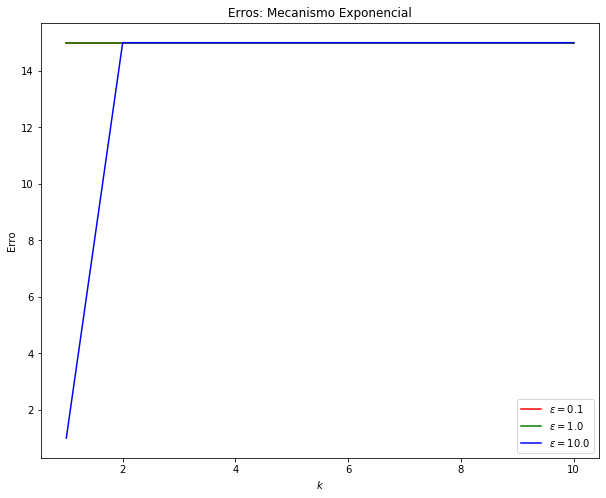

In [95]:
cores = ['red', 'green', 'blue']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_exponencial, budgets, cores):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'$\epsilon = %.1f$' % (budget))
    
plt.xlabel('$k$')
plt.ylabel('Erro')
plt.title('Erros: Mecanismo Exponencial')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

# PLOT COMPARATIVO DE ERROS

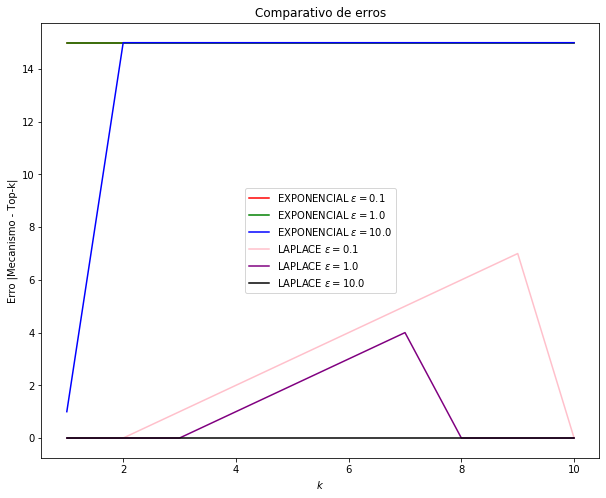

In [96]:
cores_exp = ['red', 'green', 'blue']
cores_lap = ['pink', 'purple', 'black']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for erro, budget, cor in zip(erros_exponencial, budgets, cores_exp):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'EXPONENCIAL $\epsilon= %.1f$' % (budget))

for erro, budget, cor in zip(erros_laplace, budgets, cores_lap):    
    plt.plot(eixo_x, erro, ls='-', c=cor, label=r'LAPLACE $\epsilon= %.1f$' % (budget))

plt.xlabel('$k$')
plt.ylabel('Erro |Mecanismo - Top-k|')
plt.title('Comparativo de erros')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()